In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [ ]:
!pip install timm

In [ ]:
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import timm

In [ ]:
torchvision.__version__

'0.16.0+cu118'

In [ ]:
torch.__version__

'2.1.0+cu118'

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

# 1. Dataset and Data Loader

In [ ]:
!unzip '/content/drive/MyDrive/Cards_Image_Dataset.zip' -d '/content'

In [ ]:
class PlayingCardDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data = ImageFolder(data_dir, transform=transform)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

    @property
    def classes(self):
        return self.data.classes

In [ ]:
dataset = PlayingCardDataset(
    data_dir='/content/train'
)

In [ ]:
len(dataset)

7624

41


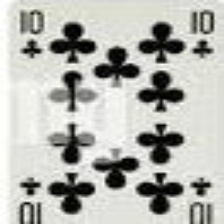

In [ ]:
image, label = dataset[6000]
print(label)
image

In [ ]:
data_dir = '/content/train'
target_to_class = {v: k for k, v in ImageFolder(data_dir).class_to_idx.items()}
target_to_class

{0: 'ace of clubs',
 1: 'ace of diamonds',
 2: 'ace of hearts',
 3: 'ace of spades',
 4: 'eight of clubs',
 5: 'eight of diamonds',
 6: 'eight of hearts',
 7: 'eight of spades',
 8: 'five of clubs',
 9: 'five of diamonds',
 10: 'five of hearts',
 11: 'five of spades',
 12: 'four of clubs',
 13: 'four of diamonds',
 14: 'four of hearts',
 15: 'four of spades',
 16: 'jack of clubs',
 17: 'jack of diamonds',
 18: 'jack of hearts',
 19: 'jack of spades',
 20: 'joker',
 21: 'king of clubs',
 22: 'king of diamonds',
 23: 'king of hearts',
 24: 'king of spades',
 25: 'nine of clubs',
 26: 'nine of diamonds',
 27: 'nine of hearts',
 28: 'nine of spades',
 29: 'queen of clubs',
 30: 'queen of diamonds',
 31: 'queen of hearts',
 32: 'queen of spades',
 33: 'seven of clubs',
 34: 'seven of diamonds',
 35: 'seven of hearts',
 36: 'seven of spades',
 37: 'six of clubs',
 38: 'six of diamonds',
 39: 'six of hearts',
 40: 'six of spades',
 41: 'ten of clubs',
 42: 'ten of diamonds',
 43: 'ten of hear

In [ ]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

dataset = PlayingCardDataset(data_dir, transform)

In [ ]:
image, label = dataset[100]
image.shape

torch.Size([3, 128, 128])

In [ ]:
for image, label in dataset:
    break

In [ ]:
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [ ]:
for images, labels in dataloader:
    break

In [ ]:
images.shape, labels.shape

(torch.Size([32, 3, 128, 128]), torch.Size([32]))

In [ ]:
labels

tensor([27, 52, 19,  4, 43, 24, 15, 28, 26, 19,  0, 25, 38,  2, 10,  1, 25, 25,
         1, 32, 19, 12, 31, 29, 39, 10, 43, 11,  0, 12, 42,  9])

# 2. PyTorch Model

In [ ]:
class SimpleCardClassifier(nn.Module):
    def __init__(self,num_classes=53):
        super(SimpleCardClassifier,self).__init__()
        self.base_model = timm.create_model('efficientnet_b0',pretrained=True)
        self.features = nn.Sequential(*list(self.base_model.children())[:-1])
        enet_out_Size = 1280
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(enet_out_Size,num_classes)
        )

    def forward(self,x):
        x = self.features(x)
        output = self.classifier(x)
        return output

In [ ]:
model = SimpleCardClassifier(num_classes=53)

model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

In [ ]:
print(str(model))

SimpleCardClassifier(
  (base_model): EfficientNet(
    (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNormAct2d(
      32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn1): BatchNormAct2d(
            32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): SiLU(inplace=True)
          )
          (se): SqueezeExcite(
            (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (act1): SiLU(inplace=True)
            (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (gate): Sigmoid()
          )
          (conv_pw): Conv2d(32, 16, ke

In [ ]:
model(images).shape   #[batch_size,num_classes]

torch.Size([32, 53])

# 3. Training the Model

### (i) Setting up Datasets

In [ ]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

train_folder = '/content/train/'
valid_folder = '/content/valid/'
test_folder = '/content/test/'

train_dataset = PlayingCardDataset(train_folder, transform=transform)
val_dataset = PlayingCardDataset(valid_folder, transform=transform)
test_dataset = PlayingCardDataset(test_folder, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

### (ii) Training Loop

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
device

device(type='cuda', index=0)

In [ ]:
epochs = 5
train_losses, val_losses = [], []

model = SimpleCardClassifier(num_classes=53)
model.to(device)

loss_calc = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for images, labels in tqdm(train_loader, desc="Training Loop"):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_calc(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * labels.size(0)
    train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(train_loss)

    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc='Validation Loop'):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = loss_calc(outputs, labels)
            running_loss += loss.item() * labels.size(0)
    val_loss = running_loss / len(val_loader.dataset)
    val_losses.append(val_loss)
    print(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_loss}, Validation Loss: {val_loss}")

Training Loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation Loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 1/5 - Train Loss: 1.5467375998481998, Validation Loss: 0.397977788043472


Training Loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation Loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 2/5 - Train Loss: 0.5410841929825005, Validation Loss: 0.3485554209295309


Training Loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation Loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 3/5 - Train Loss: 0.34013479027080135, Validation Loss: 0.2487393356719107


Training Loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation Loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 4/5 - Train Loss: 0.24476186100858707, Validation Loss: 0.13652382082534287


Training Loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation Loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 5/5 - Train Loss: 0.18987563619896347, Validation Loss: 0.21313464956463507


### (iii) Visualize Losses

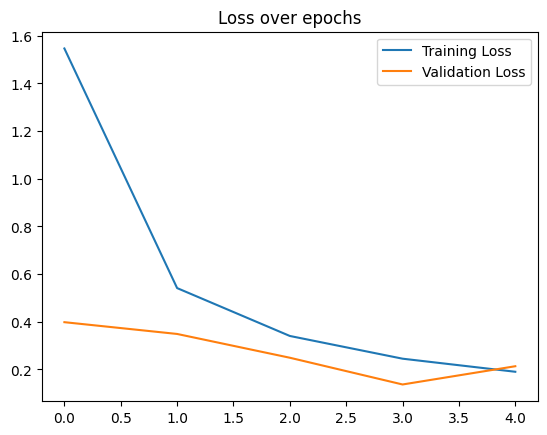

In [ ]:
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.legend()
plt.title("Loss over epochs")
plt.show()

### (iv) Evaluating Results

In [ ]:
from PIL import Image

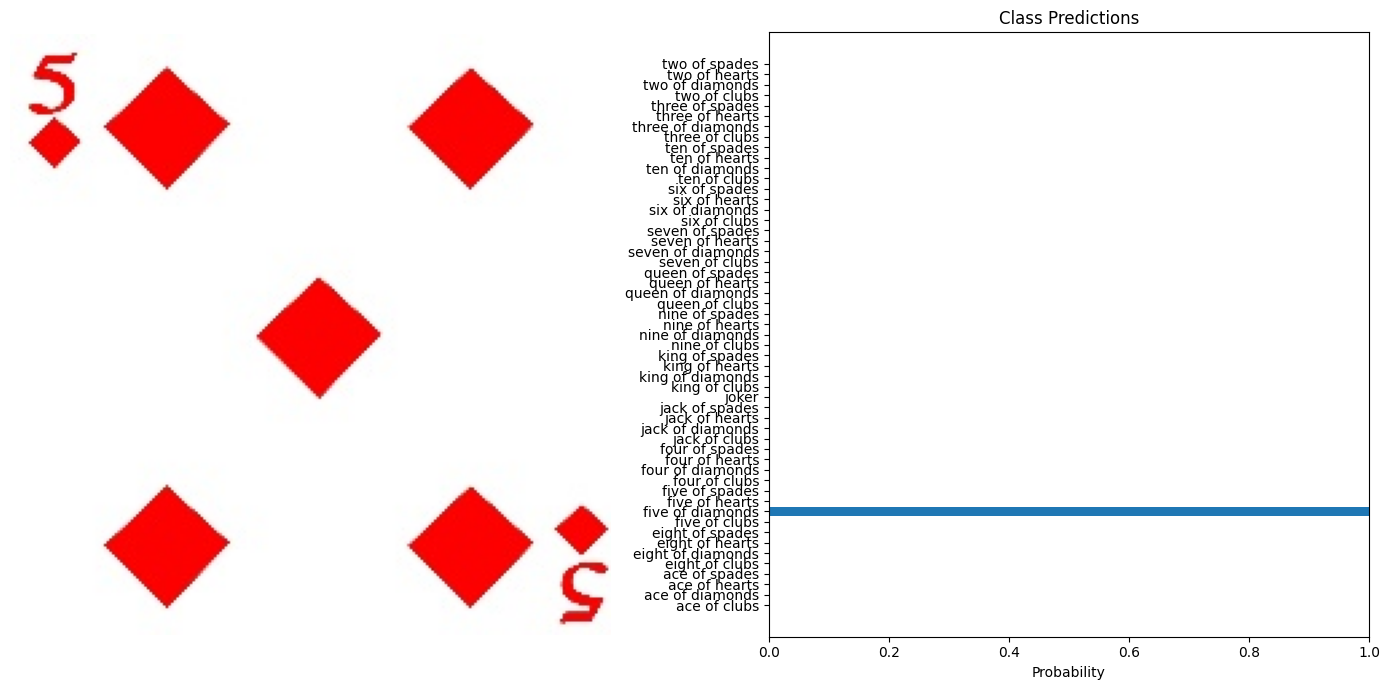

In [ ]:
def preprocess_image(image_path, transform):
    image = Image.open(image_path).convert('RGB')
    return image, transform(image).unsqueeze(0)

def predict(model, image_tensor, device):
    model.eval()
    with torch.no_grad():
        image_tensor = image_tensor.to(device)
        outputs = model(image_tensor)
        probs = torch.nn.functional.softmax(outputs, dim=1)
    return probs.cpu().numpy().flatten()

def visualize_pred(original_image, probs, class_names):
    fig, axarr = plt.subplots(1, 2, figsize=(14,7))
    axarr[0].imshow(original_image)
    axarr[0].axis("off")

    axarr[1].barh(class_names, probs)
    axarr[1].set_xlabel("Probability")
    axarr[1].set_title("Class Predictions")
    axarr[1].set_xlim(0,1)

    plt.tight_layout()
    plt.show()

test_image = "/content/test/five of diamonds/2.jpg"
transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor()
])

original_image, image_tensor = preprocess_image(test_image, transform)
probs = predict(model, image_tensor, device)

class_names = dataset.classes
visualize_pred(original_image, probs, class_names)

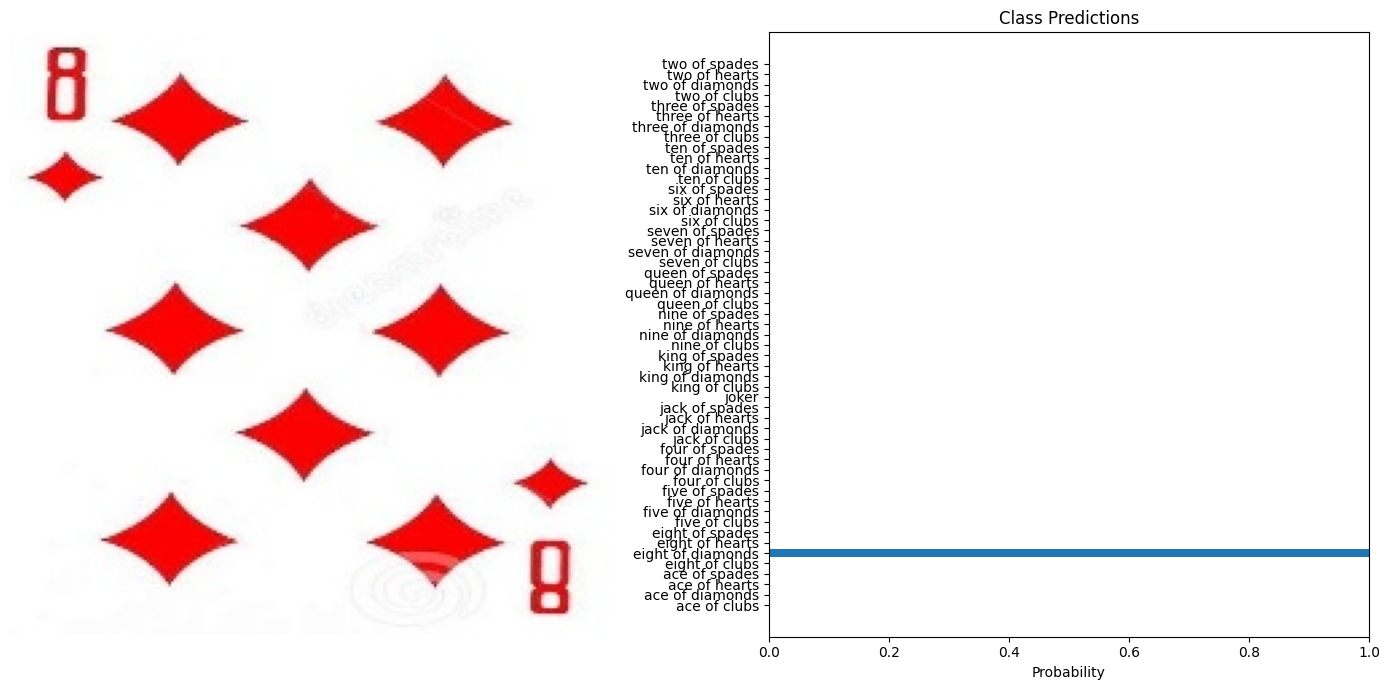

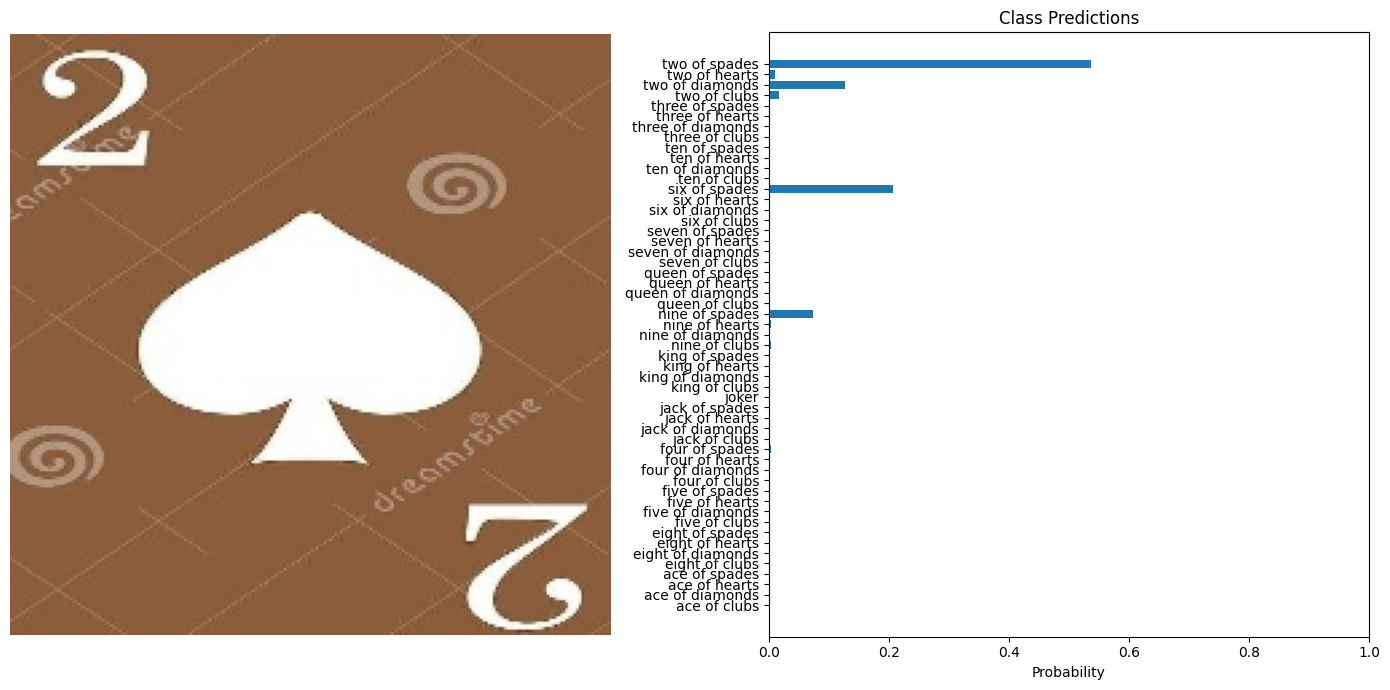

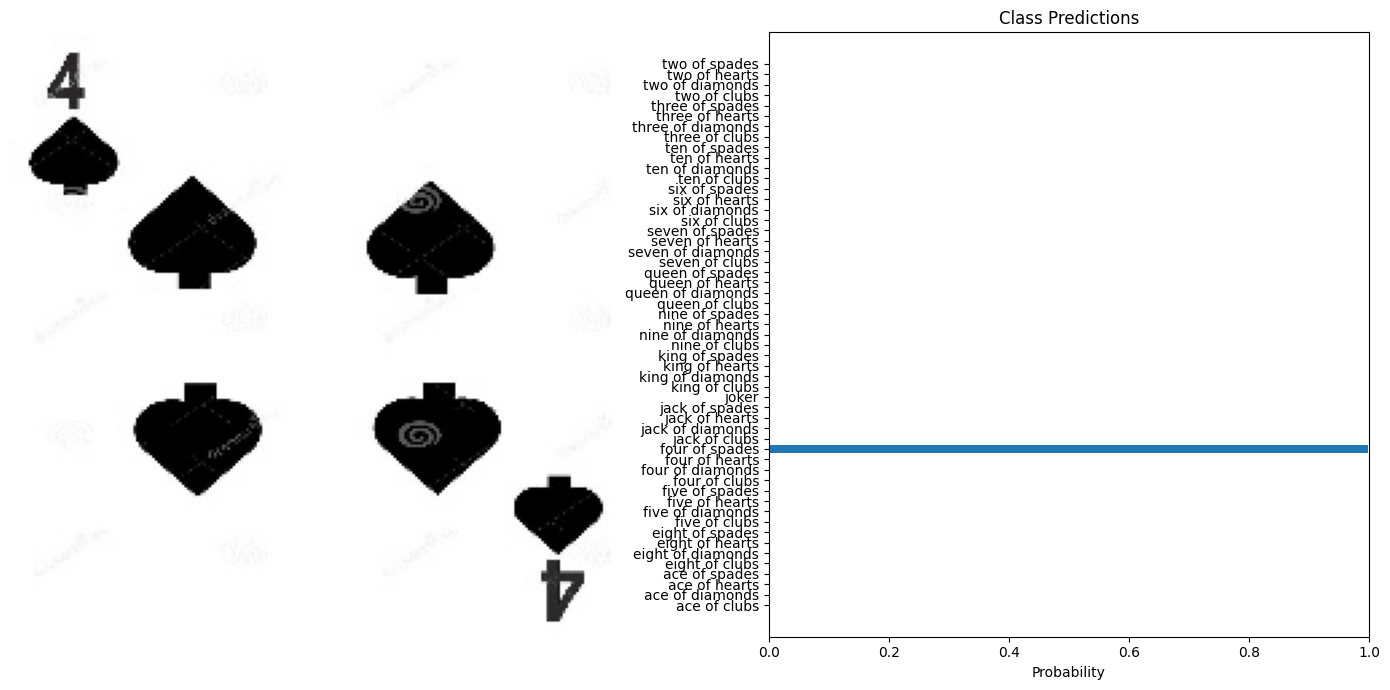

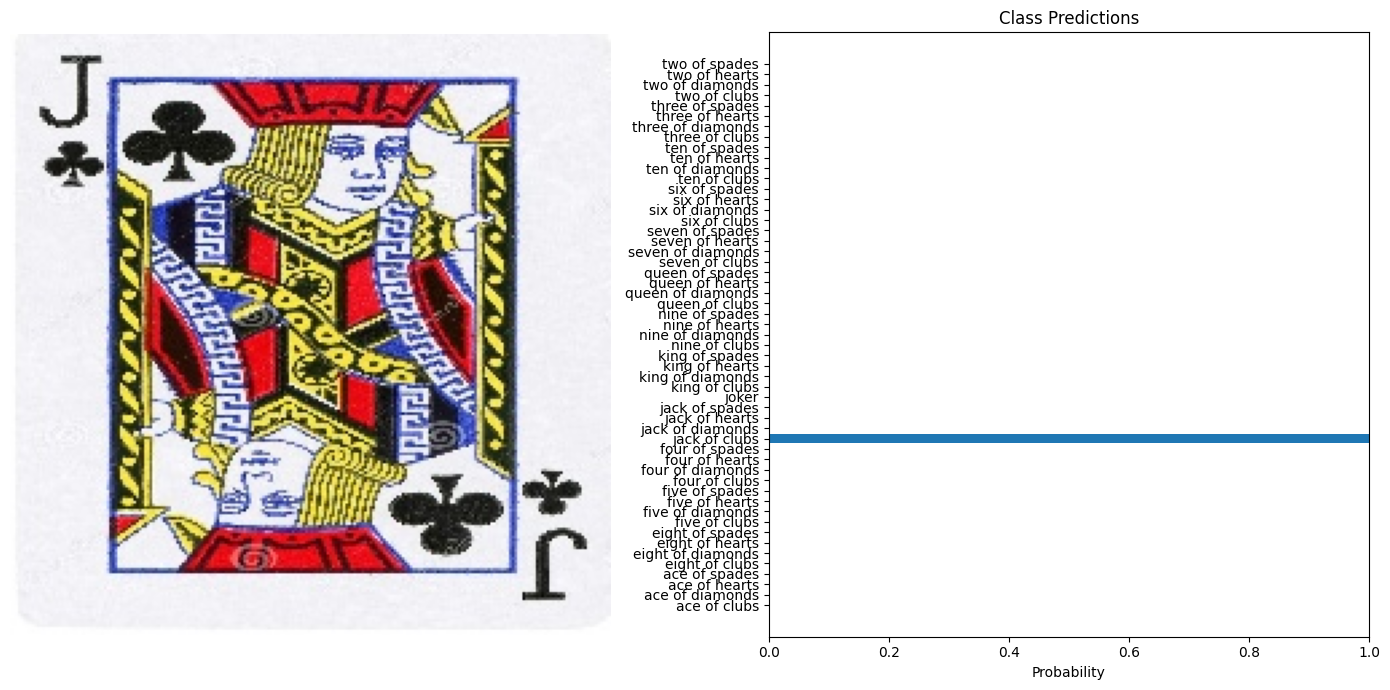

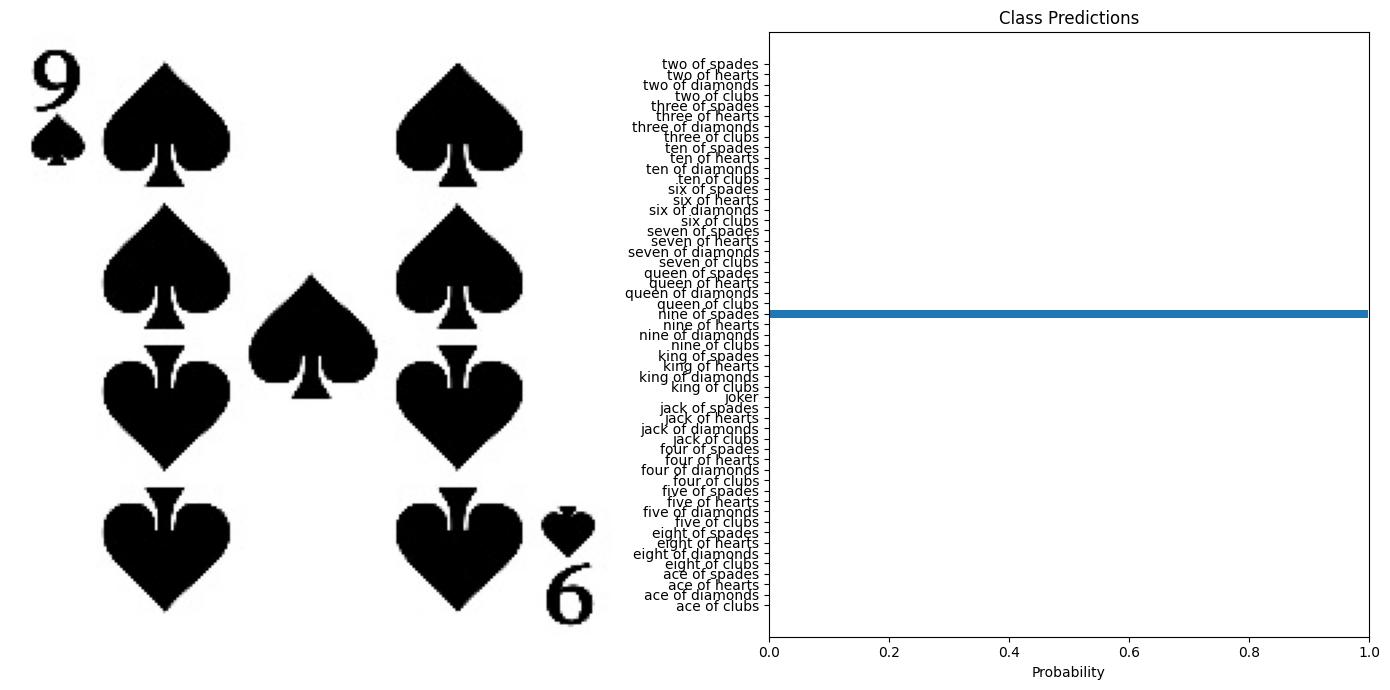

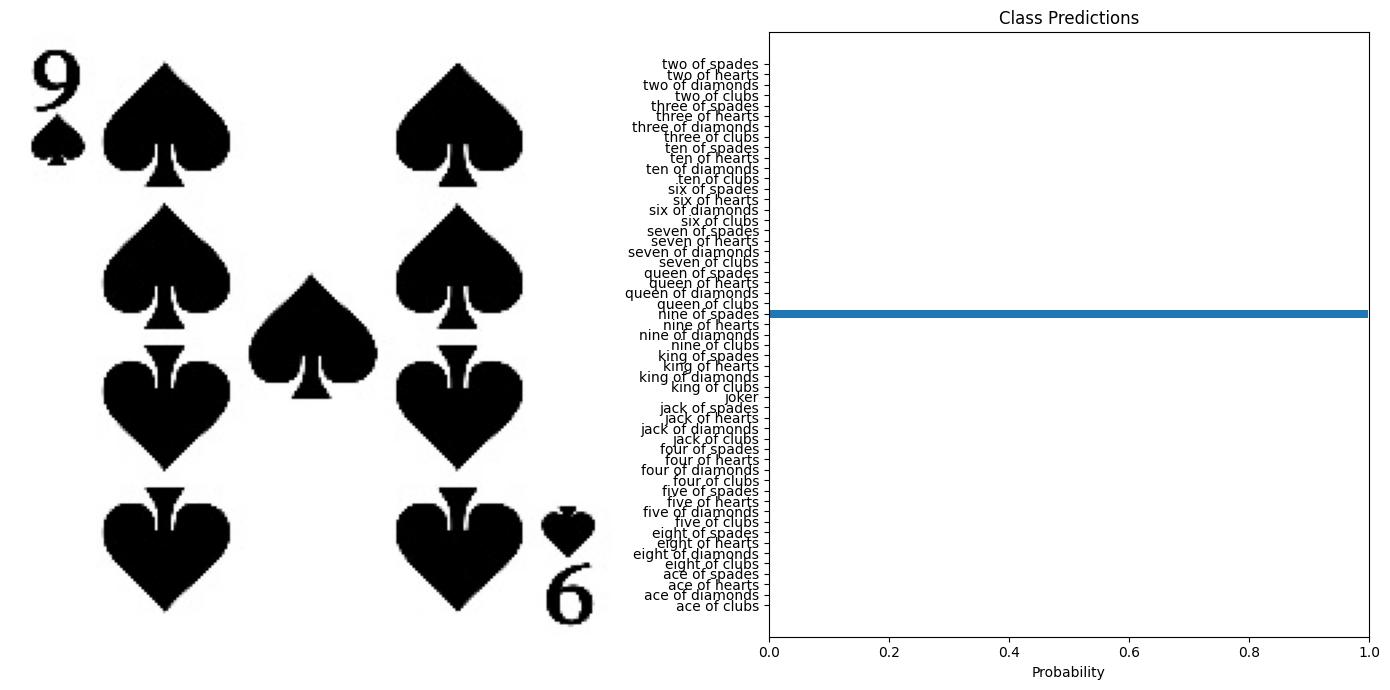

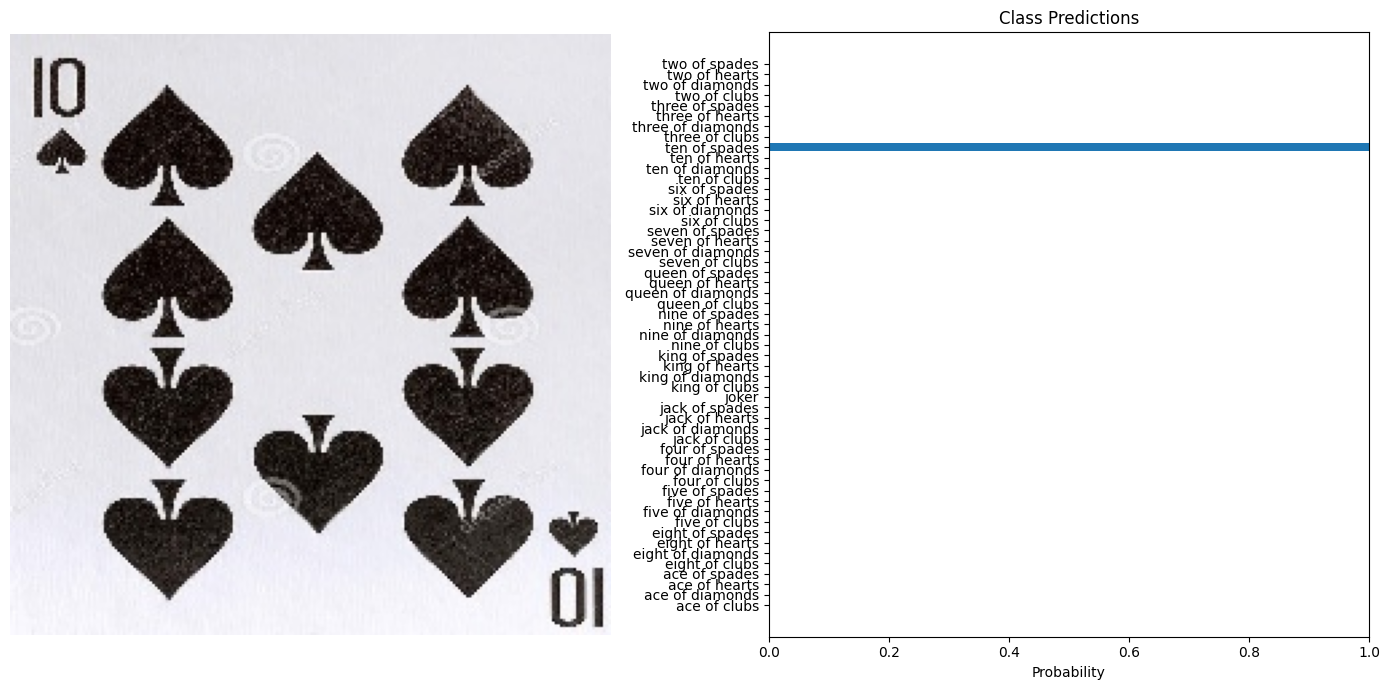

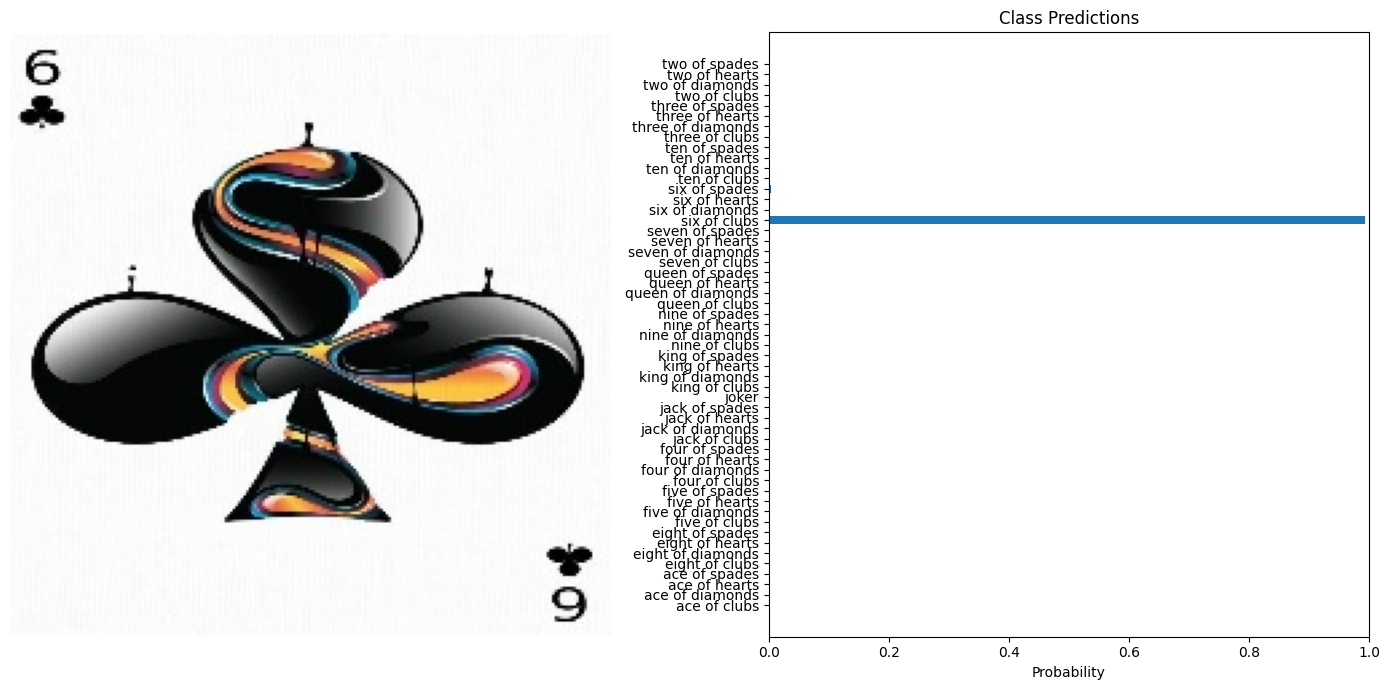

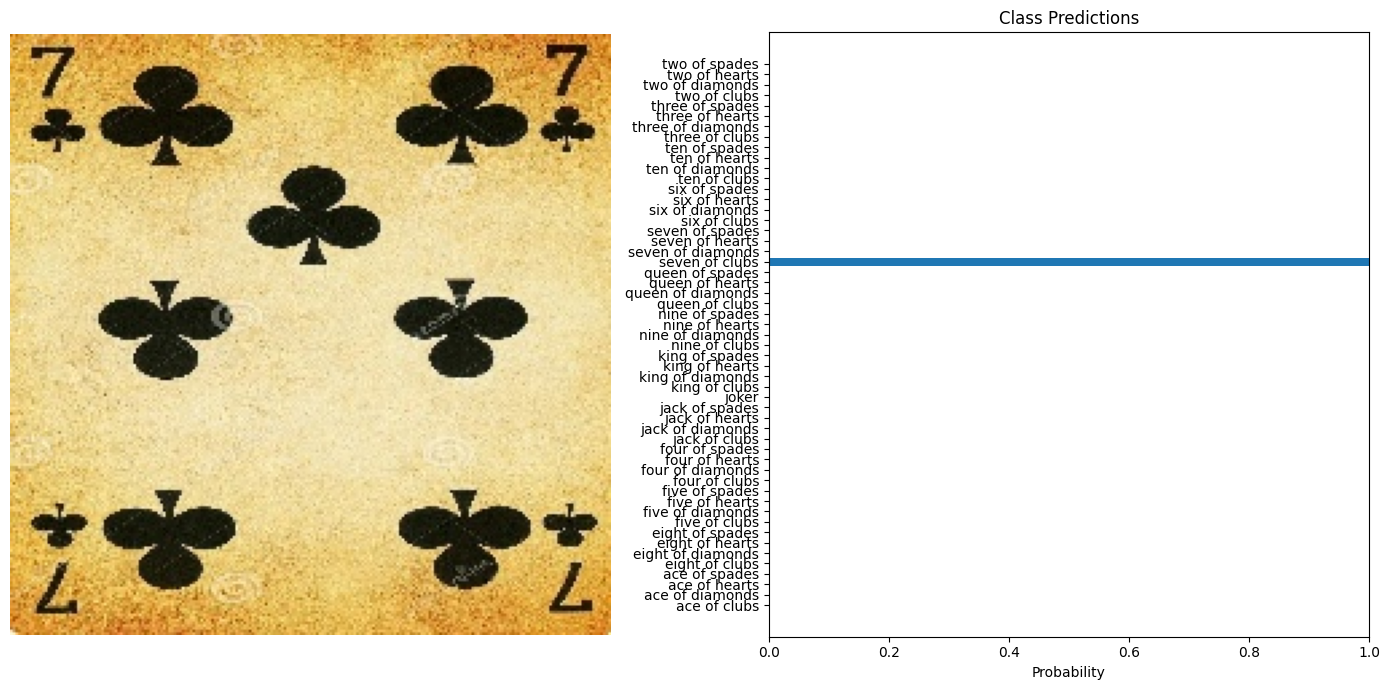

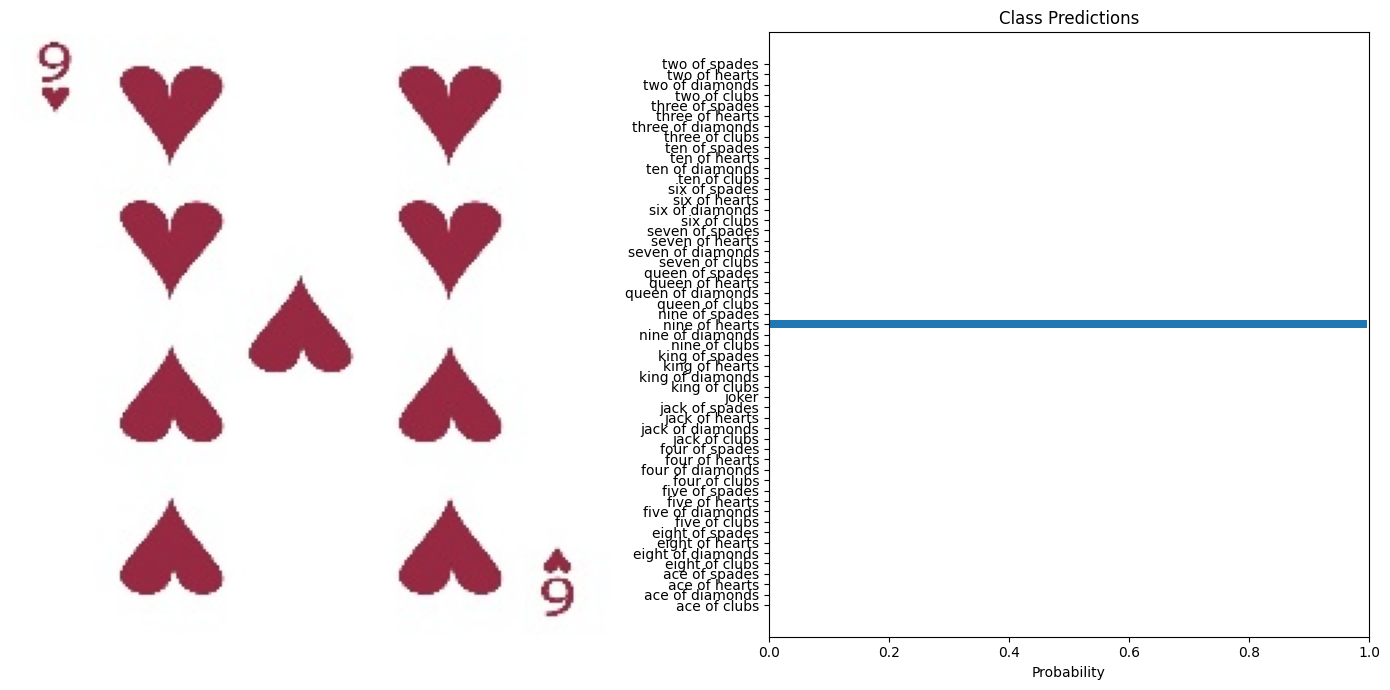

In [ ]:
from glob import glob
test_images = glob('/content/test/*/*')
test_examples = np.random.choice(test_images, 10)

for example in test_examples:
    original_image, image_tensor = preprocess_image(example, transform)
    probs = predict(model, image_tensor, device)

    class_names = dataset.classes
    visualize_pred(original_image, probs, class_names)